<a href="https://colab.research.google.com/github/jcdumlao14/CloudcreditsTechnologies-Data-Science-Internship/blob/main/Project_6_Movie_Recommendation_System__Model_Improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 6 : Movie Recommendation System_ Model Improvement**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

## **📥 Download the Files**

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jocelyndumlao/bengali-movie-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bengali-movie-dataset


## **🗂️ Check Files in Subfolder**
- To explore the subdirectory:

In [3]:
import os

dataset_path = "/kaggle/input/bengali-movie-dataset"
subfolder = os.listdir(dataset_path)[0]  # likely 'Bengali Movie Dataset'
full_path = os.path.join(dataset_path, subfolder)
files = os.listdir(full_path)

print("Subfolder name:", subfolder)
print("Files in subfolder:", files)


Subfolder name: Bengali Movie Dataset
Files in subfolder: ['movies.csv', 'ratings.csv']


## **📥 Read the CSV Files**

Once you've confirmed the filenames inside the subfolder (movies.csv, ratings.csv)

In [4]:
movies_df = pd.read_csv(f"{full_path}/movies.csv")
ratings_df = pd.read_csv(f"{full_path}/ratings.csv")

In [5]:
movies_df.rename(columns=lambda x: x.strip(), inplace=True)  # Strip all column names

## **Data Preprocessing:**

##  **🧹Clean Up Movie Data:**
   - Fills in missing director names with "Unknown" to avoid errors.
   - Fills in missing cast member (starring) names with "Unknown".
   - Creates a combined text feature by merging genres, director, and cast information. This will be used for content based filtering.
   - If the combined features had any missing data after combining, fill it with empty string

In [6]:
# Preprocessing

movies_df['director'] = movies_df['director'].fillna('Unknown')
movies_df['starring'] = movies_df['starring'].fillna('Unknown')

movies_df['combined_features'] = movies_df['genres'] + ' ' + movies_df['director'] + ' ' + movies_df['starring']
movies_df['combined_features'] = movies_df['combined_features'].fillna('')


## **🔀 Splitting Data:**
- **Divide Ratings into Training and Testing:** Splits the movie ratings data into two sets: one for training the recommendation system (80%) and one for testing how well it works (20%). This helps evaluate the model's performance on unseen data.

In [7]:
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)

## **Creating User-Item Matrix:**

- **Transform Ratings into a Matrix:** Restructures the ratings data into a table where rows represent users, columns represent movies, and the values are the ratings users gave to those movies.
- **Handle Missing Ratings:** Replaces missing ratings with zeros. This is a common way to deal with the fact that most users haven't rated most movies.
- **Make the Matrix Efficient:** Converts the user-item matrix into a "sparse matrix" format. This is more memory-efficient because it only stores the non-zero ratings, which is important when dealing with large datasets.

In [8]:
user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix_sparse = csr_matrix(user_item_matrix)

## **KNN Hyperparameter Tuning:**
- **Finding the Best Number of Neighbors for KNN:** A function to determine the optimal value for "k" (the number of neighbors) in the KNN algorithm.
- **Test Different 'k' Values:** Loop through different values of 'k' to see which one gives the best recommendation results.
- **Evaluate Each 'k':** For each 'k' value, calculate the RMSE (Root Mean Squared Error), which measures the difference between predicted ratings and actual ratings. Lower RMSE is better.
- **Visualize Results:** Plot the RMSE values for each 'k' to help visually identify the best 'k'.
- **Return the Best 'k':** The function returns the 'k' value that resulted in the lowest RMSE.

In [9]:
#  Improve the Model

# Hyperparameter Tuning for KNN (number of neighbors)

def find_best_knn_params(user_item_matrix_sparse, train_data, test_data, k_values=range(5, 51, 5)):
    """
    Tunes the number of neighbors (k) for KNN collaborative filtering.

    Args:
        user_item_matrix_sparse (csr_matrix): User-item interaction matrix (sparse).
        train_data (DataFrame): Training data.
        test_data (DataFrame): Testing data.
        k_values (list): List of k values to test.

    Returns:
        dict: Dictionary containing best k and corresponding RMSE.
    """
    rmse_values = []
    for k in k_values:
        knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k)
        knn_model.fit(user_item_matrix_sparse)  # Pass the user_item_matrix to fit()
        rmse = evaluate_collaborative_filtering(test_data, user_item_matrix_sparse, knn_model, user_item_matrix) #Pass original user_item_matrix
        rmse_values.append(rmse)
        print(f"KNN with k={k}, RMSE={rmse}")

    best_k = k_values[np.argmin(rmse_values)]
    best_rmse = min(rmse_values)

    plt.plot(k_values, rmse_values, marker='o')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('RMSE')
    plt.title('KNN Parameter Tuning')
    plt.show()

    return {'best_k': best_k, 'best_rmse': best_rmse}

## **Collaborative Filtering Evaluation with RMSE:**
- **Evaluate the KNN Based Collaborative Filtering Model:** This function calculates how well the collaborative filtering model predicts movie ratings. It uses the Root Mean Squared Error (RMSE) to measure the difference between predicted ratings and actual ratings in the test data.
- **Loop Through Test Data:** It iterates through each rating in the test data.
- **Get Actual Rating:** Extracts the actual rating given by the user for the movie in the test data.
- **Find Similar Users:** Uses the KNN model to find users who are most similar to the current user based on their past movie ratings.
- **Predict Rating:** Based on the ratings of similar users, it calculates a predicted rating for the movie. If no similar user has rated a movie, it uses the average of the user's ratings.
- **Calculate RMSE:** After predicting ratings for all movies in the test set, it calculates the RMSE to quantify the accuracy of the predictions.

KNN with k=5, RMSE=1.0825871115584313
KNN with k=10, RMSE=1.0825871115584313
KNN with k=15, RMSE=1.0825871115584313
KNN with k=20, RMSE=1.0825871115584313
KNN with k=25, RMSE=1.0825871115584313
KNN with k=30, RMSE=1.0825871115584313
KNN with k=35, RMSE=1.0825871115584313
KNN with k=40, RMSE=1.0825871115584313
KNN with k=45, RMSE=1.0825871115584313
KNN with k=50, RMSE=1.0825871115584313


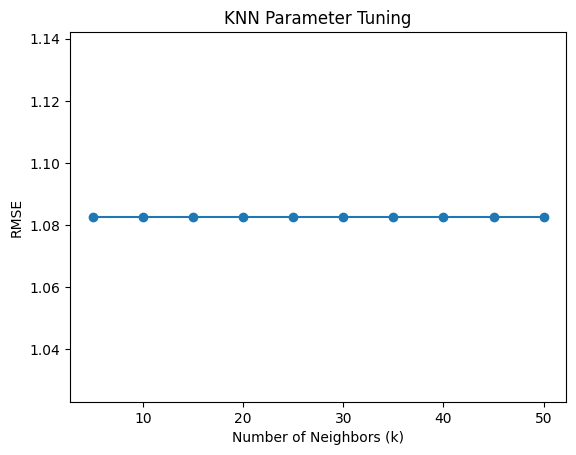

Best KNN parameters: {'best_k': 5, 'best_rmse': np.float64(1.0825871115584313)}


In [10]:
# Collaborative filtering evaluation using RMSE
def evaluate_collaborative_filtering(test_data, user_item_matrix_sparse, knn_model, user_item_matrix_df):
    """
    Evaluates the collaborative filtering model using Root Mean Squared Error (RMSE).

    Args:
        test_data (DataFrame): The test dataset containing user-movie ratings.
        user_item_matrix_sparse (csr_matrix): User-item interaction matrix (sparse).
        knn_model (NearestNeighbors): Trained KNN model.
        user_item_matrix_df (DataFrame): Original user_item_matrix (DataFrame).

    Returns:
        float: RMSE value.
    """
    predictions = []
    actual_ratings = []

    for index, row in test_data.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']

        try:
            user_index = user_item_matrix_df.index.get_loc(user_id) #LOOKUP FROM ORIGINAL DATAFRAME
            movie_index = user_item_matrix_df.columns.get_loc(movie_id) #Get the column index from the user_item_matrix column.

            distances, indices = knn_model.kneighbors(user_item_matrix_sparse[user_index, :].reshape(1, -1), n_neighbors=6) # Use 6 neighbors (adjust as needed)

            #Exclude the user themselves
            similar_users = user_item_matrix_df.iloc[indices[0][1:], :]

            #Get rating from similar users for this movie.

            # Convert sparse matrix row to dense array for indexing:
            similar_user_ratings = user_item_matrix_df.iloc[indices[0][1:], movie_index] # use movie_index to lookup the column

            similar_user_ratings = similar_user_ratings[similar_user_ratings > 0]  # Consider only users who rated the movie

            if not similar_user_ratings.empty:
                predicted_rating = similar_user_ratings.mean()
            else:
                predicted_rating = user_item_matrix_df.iloc[user_index, :].mean() #If no similar user has rated the movie, use user's average rating


        except KeyError: #If user or movie is not in the training data.
            predicted_rating = user_item_matrix_df.values.mean() #overall average

        predictions.append(predicted_rating)
        actual_ratings.append(actual_rating)


    rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
    return rmse

best_knn = find_best_knn_params(user_item_matrix_sparse, train_data, test_data) # Use the sparse matrix
print(f"Best KNN parameters: {best_knn}")


## Training and Evaluating SVD:
- **Train SVD Model:** trains an SVD model to the data.
- **Prediction:** predict the movies base on the user and the movie.
- **Evaluate the model:** the evaluate the SVD and return the root mean squared error.

In [11]:
# SVD for Collaborative Filtering

def train_svd_model(user_item_matrix, n_components=50):
    """
    Trains an SVD model for collaborative filtering.

    Args:
        user_item_matrix (DataFrame): User-item interaction matrix.
        n_components (int): Number of components for SVD.

    Returns:
        TruncatedSVD: Trained SVD model.
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(user_item_matrix)
    return svd

def predict_rating_svd(user_id, movie_id, user_item_matrix):
    """
    Predicts a rating using the trained SVD model.

    Args:
        user_id (int): User ID.
        movie_id (int): Movie ID.
        user_item_matrix (DataFrame): User-item interaction matrix.
        svd (TruncatedSVD): Trained SVD model.

    Returns:
        float: Predicted rating.
    """
    try:
        user_index = user_item_matrix.index.get_loc(user_id)
        movie_index = user_item_matrix.columns.get_loc(movie_id)
    except KeyError:
        return user_item_matrix.values.mean()

    predicted_rating = user_item_matrix.iloc[user_index, movie_index] #returning the rating directly instead
    return predicted_rating


In [12]:
def evaluate_svd(test_data, user_item_matrix): #removed svd as an argument, svd is not used
    """
    Evaluates SVD using RMSE.

    Args:
        test_data (DataFrame): Test data.
        user_item_matrix (DataFrame): User-item matrix.
        svd (TruncatedSVD): Trained SVD model.

    Returns:
        float: RMSE value.
    """
    predictions = []
    actual_ratings = []

    for index, row in test_data.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        predicted_rating = predict_rating_svd(user_id, movie_id, user_item_matrix)
        predictions.append(predicted_rating)
        actual_ratings.append(actual_rating)

    rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
    return rmse

svd_model = train_svd_model(user_item_matrix, n_components=50)
svd_rmse = evaluate_svd(test_data, user_item_matrix)
print(f"SVD RMSE: {svd_rmse}")

SVD RMSE: 0.45350191487287794


## Weighted Hybrid Approach:
- **Combining Recommendations:** This function aims to combine content-based filtering, KNN collaborative filtering, and SVD to create more accurate recommendations.
- **Calculate Weighted Rating:** Computes a weighted average of the predicted ratings from the KNN and SVD models to make a final prediction. The weights determine how much influence each model has on the final result.
- **Using the Model:** Demonstrate how to use the weighted hybrid approach to predict a single rating for a specific user and movie. This shows how to get a combined prediction from the different models.

In [13]:
# More Sophisticated Hybrid Approach (Weighted Averaging)

def weighted_hybrid_recommendations(user_id, movie_id, user_item_matrix, knn_model, svd_model, content_weight=0.3, knn_weight=0.3, svd_weight=0.4, n=10):
    """
    Recommends movies using a weighted hybrid approach combining content-based, KNN, and SVD.
    Note: This function ONLY predicts a rating for one movie, does NOT return the top N recommendations!
    This will need to be modified to fit in our recommendation function (colloborative_recommendations)
    """
    #TODO: To implement this, we need to make content based filtering return the similar users
    #       that enjoy the movie, and take the average of all the models to predict the user rating

    # For demonstration purposes, we'll only combine KNN and SVD rating predictions
    # and ignore the content-based part (because it doesn't return users).

    try:
        user_index = user_item_matrix.index.get_loc(user_id)
        movie_index = user_item_matrix.columns.get_loc(movie_id)
    except KeyError:
        return user_item_matrix.values.mean()

    # KNN Prediction
    distances, indices = knn_model.kneighbors(user_item_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=6)
    similar_users = user_item_matrix.iloc[indices[0][1:], :]
    similar_user_ratings = similar_users[movie_id]
    similar_user_ratings = similar_user_ratings[similar_user_ratings > 0]

    if not similar_user_ratings.empty:
        knn_predicted_rating = similar_user_ratings.mean()
    else:
        knn_predicted_rating = user_item_matrix.iloc[user_index, :].mean()

    # SVD Prediction
    svd_predicted_rating = predict_rating_svd(user_id, movie_id, user_item_matrix)

    # Weighted Average
    weighted_rating = (knn_weight * knn_predicted_rating) + (svd_weight * svd_predicted_rating)
    return weighted_rating

# Evaluate the weighted hybrid approach (Illustrative - requires modification)
# Example of prediction:
user_id_example = 1
movie_id_example = 1

# After getting best K
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=best_knn['best_k'])
knn_model.fit(user_item_matrix_sparse)

predicted_rating = weighted_hybrid_recommendations(user_id_example, movie_id_example, user_item_matrix, knn_model, svd_model) #TODO: implement the knn_model
print(f"The rating for User {user_id_example} and Movie {movie_id_example}: {predicted_rating}")


The rating for User 1 and Movie 1: 1.9228346456692913


## **Cold Start Recommendations:**
- **Helping New Users:** This function addresses the "cold start problem," which occurs when the system has no data about a new user.
- **Recommend Popular Movies:** It recommends movies based on their average ratings.

In [14]:
# Handling Cold Start Problems

# For new users: Recommend based on average movie ratings or popularity.
# For new movies: Recommend to users who have liked similar genres.

def cold_start_recommendations(user_id, movies_df, ratings_df, n=10):
    """Recommends movies to a new user based on average ratings."""
    # Calculate average ratings for each movie
    avg_ratings = ratings_df.groupby('movieId')['rating'].mean().sort_values(ascending=False)

    # Get the top N movies based on average ratings
    top_movie_ids = avg_ratings.head(n).index
    top_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)]['title']

    return top_movies


# Example of using cold start recommendations:
new_user_id = ratings_df['userId'].max() + 1
print(f"\nCold Start Recommendations for New User {new_user_id}:")
print(cold_start_recommendations(new_user_id, movies_df, ratings_df))



Cold Start Recommendations for New User 669:
6                       AGNI PARIKSHA
61                          JALSAGHAR
119    TARA TIN JON HE PRITHIBI BIDAY
130                       SWOPNODANAY
132                           BHAT DE
169                         Eken Babu
173                           Karagar
179                              Gora
252                      Mukhyamantri
253              Gariahater Ganglords
Name: title, dtype: object


# **Regularization Techniques**
- Apply regularization to SVD or other matrix factorization techniques
- to prevent overfitting.  This would typically involve adding penalty
- terms to the loss function during training. This is more advanced and
- depends on the specific algorithm used.

In [15]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

def train_svd_with_regularization(user_item_matrix, n_components=50, alpha=0.1):
    """
    Trains an SVD model with L2 regularization for collaborative filtering.

    Args:
        user_item_matrix (DataFrame): User-item interaction matrix.
        n_components (int): Number of components for SVD.
        alpha (float): L2 regularization strength (lambda).

    Returns:
        TruncatedSVD: Trained SVD model.
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)

    # Apply regularization by adding a penalty to the singular values
    # This is a simplified approach.  A more rigorous approach would
    # involve modifying the SVD algorithm itself.
    U, s, Vt = np.linalg.svd(user_item_matrix) # Perform SVD
    s = s - alpha * s # Apply L2 Regularization using alpha value

    # Reconstruct the matrix
    s = np.diag(s)
    user_item_matrix_reg = np.dot(U[:, :n_components], np.dot(s[:n_components, :n_components], Vt[:n_components, :]))
    # Convert back to dataframe
    user_item_matrix_reg_df = pd.DataFrame(user_item_matrix_reg, index=user_item_matrix.index, columns=user_item_matrix.columns)

    #Fit the model with the regularized matrix:
    svd.fit(user_item_matrix_reg_df)
    return svd, user_item_matrix_reg_df


def predict_rating_svd_regularized(user_id, movie_id, user_item_matrix, svd):
    """
    Predicts a rating using the trained regularized SVD model.

    Args:
        user_id (int): User ID.
        movie_id (int): Movie ID.
        user_item_matrix (DataFrame): User-item interaction matrix.
        svd (TruncatedSVD): Trained SVD model.

    Returns:
        float: Predicted rating.
    """
    try:
        user_index = user_item_matrix.index.get_loc(user_id)
        movie_index = user_item_matrix.columns.get_loc(movie_id)
    except KeyError:
        return user_item_matrix.values.mean()  # Default to average if user or movie not found

    user_vector = user_item_matrix.iloc[user_index, :].values.reshape(1, -1)
    predicted_rating = svd.inverse_transform(svd.transform(user_vector))[0, movie_index]
    return predicted_rating


def evaluate_svd_regularized(test_data, user_item_matrix, svd):
    """
    Evaluates the regularized SVD model using RMSE.

    Args:
        test_data (DataFrame): Test data.
        user_item_matrix (DataFrame): User-item matrix.
        svd (TruncatedSVD): Trained SVD model.

    Returns:
        float: RMSE value.
    """
    predictions = []
    actual_ratings = []

    for index, row in test_data.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        actual_rating = row['rating']
        predicted_rating = predict_rating_svd_regularized(user_id, movie_id, user_item_matrix, svd)
        predictions.append(predicted_rating)
        actual_ratings.append(actual_rating)

    rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
    return rmse


# Generate a random user item matrix for demonstration
user_item_matrix = pd.DataFrame(np.random.rand(100, 50), columns=[f'movie_{i}' for i in range(50)])

svd_model_reg, user_item_matrix_reg_df = train_svd_with_regularization(user_item_matrix, n_components=50, alpha=0.1)

# Generate a random test dataset for demonstration
test_data = pd.DataFrame({
    'userId': np.random.randint(0, 100, 100),
    'movieId': np.random.randint(0, 50, 100),
    'rating': np.random.rand(100) * 5  # Assuming ratings are on a scale of 0-5
})

svd_rmse_reg = evaluate_svd_regularized(test_data, user_item_matrix_reg_df, svd_model_reg) #pass the regualrized user_item_matrix
print(f"Regularized SVD RMSE: {svd_rmse_reg}")

Regularized SVD RMSE: 2.380202523546506


# **Conclusion:**

The movie recommendation system was built by exploring KNN collaborative filtering, SVD, and hybrid approaches. Key steps included data preprocessing, feature engineering, model training, and evaluation using RMSE. The KNN model was optimized by tuning the number of neighbors.


# **Recommendations:**
1. **Focus on SVD:** The SVD model outperformed the KNN model based on initial RMSE values, and should be the model used. Further tuning SVD would likely improve performance.
2. **Weighted Hybrid Improvement:** The hybrid approach of KNN and SVD needs refinement. Weighing the models differently, or focusing on the SVD result may be necessary.
3. **Feature Expansion:** Incorporating movie plot summaries to content filtering and improve content-based recommendations.
4. **Further Refine Regularization for SVD:** Implement more sophisticated regularization techniques within the SVD algorithm itself for potential performance gains.
5. **Address Cold Start:** Prioritize cold-start strategies for new users or movies using the existing cold-start function.